In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_Mutation_CNA/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_Mutation/Predictions/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_Mutation_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_Mutation_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (MITOSISi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (MITOSISi)

GDSCE = pd.read_csv("GDSC_exprs.z.MITOSISi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (MITOSISi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (MITOSISi)

GDSCM = pd.read_csv("GDSC_mutations.MITOSISi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC CNA dataset (MITOSISi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [11]:
# read GDSC CNA dataset (MITOSISi)

GDSCC = pd.read_csv("GDSC_CNA.MITOSISi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

In [12]:
# change directory to read GDSC response dataset (MITOSISi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [13]:
# read GDSC response dataset (MITOSISi)

GDSCR = pd.read_csv("GDSC_response.MITOSISi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1
683665,0,-1.86219201025588,BI-2536,1,1,1
683665,0,-3.03887798334128,GW843682X,1,1,1


In [14]:
# print count of cell lines for each drug (MITOSISi)

GDSCR["drug"].value_counts()

drug
Genentech Cpd 10       771
SB-715992              770
NPK76-II-72-1          769
MPS-1-IN-1             767
GSK1070916             747
ZM-447439              694
Paclitaxel             370
GW843682X              370
S-Trityl-L-cysteine    369
BI-2536                368
VX-680                 365
Name: count, dtype: int64

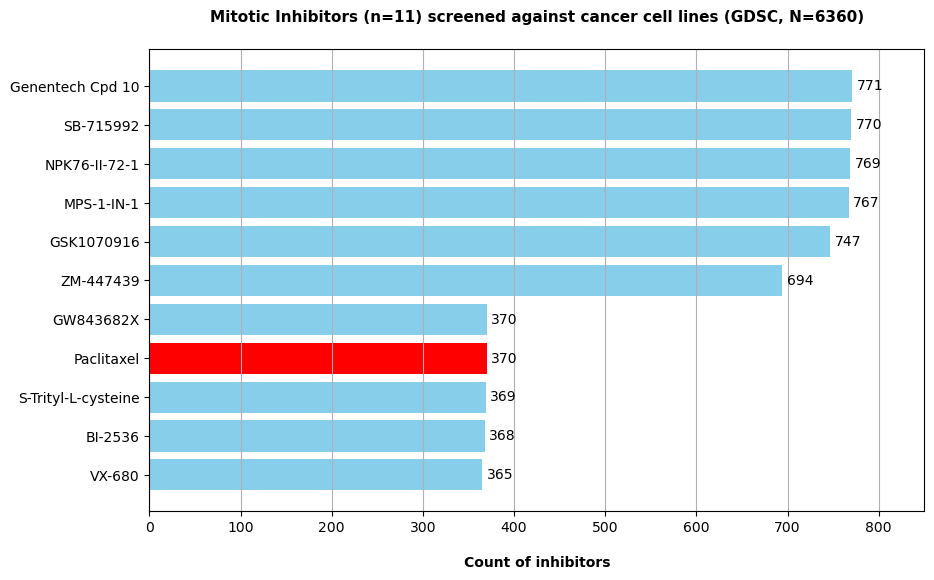

In [15]:
# plot mitotic inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Paclitaxel":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'Mitotic Inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'Mitotic Inhibitors with Their Counts (GDSC, Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [16]:
# change directory to read TCGA expression dataset homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [17]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Paclitaxel)

TCGAEpaclitaxel = pd.read_csv("TCGA_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEpaclitaxel = pd.DataFrame.transpose(TCGAEpaclitaxel)
TCGAEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-50-5068-01A,6.07077606939576,4.22435549873448,6.09703453175451,2.79409553041956,2.16511492655888,6.23897149546054,7.50971824388108,2.62136482478483,6.78739521681224,2.98021984531206,...,9.80444787373941,2.79886640790268,2.81581286530484,3.00085815257311,2.80511713535762,2.40148864399763,2.58029798170468,3.80309726320581,2.93775838077045,3.15136733303223
TCGA-53-7624-01A,3.36417856158271,1.84257380220382,4.89461611130517,3.01203072800212,1.08675483906125,2.65397613649159,8.19887134647799,2.64492131772784,9.57693655417731,2.75400746416671,...,9.87655475612095,2.79886640790268,2.81581286530484,3.47072364084828,2.92631228926461,3.04342978048926,3.85945702517433,2.76860237341666,4.70753879715127,4.40422733195751
TCGA-99-8033-01A,3.17759663469389,4.069358321802,5.30291306958158,3.04306111581331,1.71759129803103,2.9492322528108,8.35388516673678,2.61215713067395,9.55148283225251,2.62363654845594,...,9.97545462791267,2.79886640790268,2.81581286530484,3.61434933029633,2.82800183535407,2.62335146413649,2.82601101115657,2.76860237341666,4.83367880098437,4.96091320806586


In [18]:
# change directory to read TCGA mutation dataset (Paclitaxel)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [19]:
# read TCGA mutation dataset (Paclitaxel)

TCGAMpaclitaxel = pd.read_csv("TCGA_mutations.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMpaclitaxel.drop_duplicates(keep='last')
TCGAMpaclitaxel = pd.DataFrame.transpose(TCGAMpaclitaxel)
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[:, ~TCGAMpaclitaxel.columns.duplicated()]

TCGAMpaclitaxel.head(3)

,1,2,9,10,12,13,14,15,16,18,...,101929762,101929950,102723701,102724473,102724536,104472715,105375355,106478954,107075310,107161144
TCGA-50-5068-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7624-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-99-8033-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# change directory to read TCGA CNA dataset (Paclitaxel)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [21]:
# read TCGA CNA dataset (Paclitaxel)

TCGACpaclitaxel = pd.read_csv("TCGA_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGACpaclitaxel.drop_duplicates(keep='last')
TCGACpaclitaxel = pd.DataFrame.transpose(TCGACpaclitaxel)
TCGACpaclitaxel = TCGACpaclitaxel.loc[:, ~TCGACpaclitaxel.columns.duplicated()]

TCGACpaclitaxel.head(3)

gene,1,2,3,9,10,11,12,13,14,15,...,100653016,100653017,100653018,100653019,100653020,100653021,100653022,100653023,100653024,100653025
TCGA-50-5068-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7624-01A,1,0,0,-1,-1,-1,0,0,0,1,...,-1,1,1,-1,1,0,1,-1,-1,1
TCGA-99-8033-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# variance threshold for GDSC Expression dataset (MITOSISi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [23]:
# fill NA values and binarize GDSC mutation and CNA datasets (MITOSISi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1
GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [24]:
# select shared genes between GDSC and TCGA expression, mutation, and CNA datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(GDSCC.columns)
ls = ls.intersection(TCGAEpaclitaxel.columns)
ls = ls.intersection(TCGAMpaclitaxel.columns)
ls = ls.intersection(TCGACpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC and TCGA# of common genes: {ls.shape[0]}")

GDSC and TCGA# of common genes: 17249


In [25]:
# select shared samples between GDSC expression, mutation, CNA, and response datasets (MITOSISi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 799


In [26]:
# subset shared genes and samples in GDSC expression, mutation, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (799, 17249)
GDSC # of common samples and genes (Mutation): (799, 17249)
GDSC # of common samples and genes (CNA): (799, 17249)
GDSC # of samples (Response): 6360


In [27]:
# select shared samples between TCGA expression, mutation, and CNA datasets (Paclitaxel) 

ls3 = TCGAEpaclitaxel.index.intersection(TCGAMpaclitaxel.index)
ls3 = ls3.intersection(TCGACpaclitaxel.index)

print(f"TCGA # of common samples (Paclitaxel): {ls3.shape[0]}")

TCGA # of common samples (Paclitaxel): 35


In [28]:
# select shared genes and samples between TCGA expression, mutation, and CNA datasets (Paclitaxel)

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[ls3, ls]
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[ls3, ls]
TCGACpaclitaxel = TCGACpaclitaxel.loc[ls3, ls]

print(f"TCGA # of common samples and genes for Expression (Paclitaxel): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Mutation (Paclitaxel): {TCGAMpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for CNA (Paclitaxel): {TCGACpaclitaxel.shape}\n")

TCGA # of common samples and genes for Expression (Paclitaxel): (35, 17249)
TCGA # of common samples and genes for Mutation (Paclitaxel): (35, 17249)
TCGA # of common samples and genes for CNA (Paclitaxel): (35, 17249)



In [29]:
# change directory to read DEGs (MITOSISi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi


In [30]:
# read DEGs (MITOSISi)

DEGs_filtered_data = pd.read_excel("MITOSISi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and logFC| > 1|) among mitotic inhibitors\n")

DEGs_filtered_data.head()

There are 996 DEGs (p-adjusted < 0.05 and logFC| > 1|) among mitotic inhibitors



,Gene Symbol,Frequency
0,PLS3,8
1,GMFG,7
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7


In [31]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CAST', 2), ('CLECL1P', 2)]
1 input query terms found no hit:	['SLC22A18']


996

In [32]:
# assign GDSC data to new variables

exprs_z = GDSCE
mut = GDSCM
cna = GDSCC
responses = GDSCR

In [33]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1


In [34]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'BI-2536',
 'GSK1070916',
 'GW843682X',
 'Genentech Cpd 10',
 'MPS-1-IN-1',
 'NPK76-II-72-1',
 'Paclitaxel',
 'S-Trityl-L-cysteine',
 'SB-715992',
 'VX-680',
 'ZM-447439'}

In [35]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([ 683665,  683665,  683665,  683665,  683665,  683665,  683665,  683665,
        683665,  683665,
       ...
        949167,  998184, 1290771, 1298156, 1330948, 1330993, 1503364, 1509073,
       1659818, 1659819],
      dtype='int64', length=6360)

In [36]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
leukemia             696
lymphoma             626
lung_NSCLC           600
urogenital_system    538
lung_SCLC            433
aero_dig_tract       424
nervous_system       416
skin                 371
breast               311
bone                 302
large_intestine      295
digestive_system     282
neuroblastoma        276
kidney               158
pancreas             156
myeloma              145
soft_tissue          141
lung                 103
thyroid               87
Name: count, dtype: int64

In [37]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    433
glioma                       383
lung_NSCLC_adenocarcinoma    371
melanoma                     343
breast                       311
Name: count, dtype: int64

In [38]:
# get count of total BRCA and NSCLC tissues

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["breast"].astype(int) + \
                         tissues["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues["lung_NSCLC_large cell"].astype(int) + \
                         tissues["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues["lung_NSCLC_not specified"].astype(int) + \
                         tissues["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

911

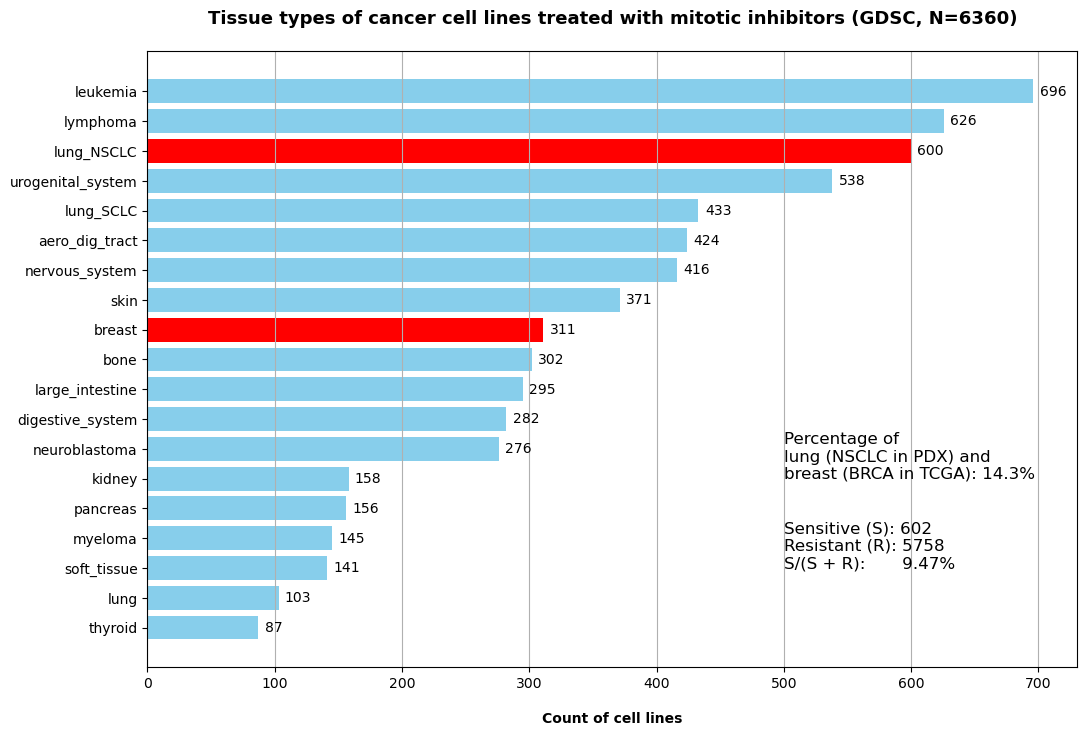

In [39]:
# plot tissue types of cancer cell lines treated with mitotic inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with mitotic inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(500, 13, 
         f'Percentage of \nlung (NSCLC in PDX) and \nbreast (BRCA in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(500, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with Mitotic Inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [40]:
# list count of cell lines as to tissues treated with paclitaxel

filter = (dat["drug"] == "Paclitaxel")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             64
lymphoma             57
lung_SCLC            35
nervous_system       25
neuroblastoma        23
lung_NSCLC           20
bone                 20
skin                 19
urogenital_system    16
large_intestine      15
aero_dig_tract       14
myeloma              13
digestive_system     12
breast               11
kidney               10
soft_tissue           9
lung                  3
pancreas              2
thyroid               2
Name: count, dtype: int64

In [41]:
# list count of cell lines as to tissues treated with paclitaxel

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Paclitaxel")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    35
acute_myeloid_leukaemia      25
neuroblastoma                23
B_cell_lymphoma              23
glioma                       23
Name: count, dtype: int64

In [42]:
# count of BRCA and NSCLC cell lines treated with paclitaxel

count_selected_tissues = tissues_drug["breast"].astype(int) + \
                         tissues_drug["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_large cell"].astype(int) + \
                         tissues_drug["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_not specified"].astype(int) + \
                         tissues_drug["lung_NSCLC_carcinoid"].astype(int) 

count_selected_tissues

31

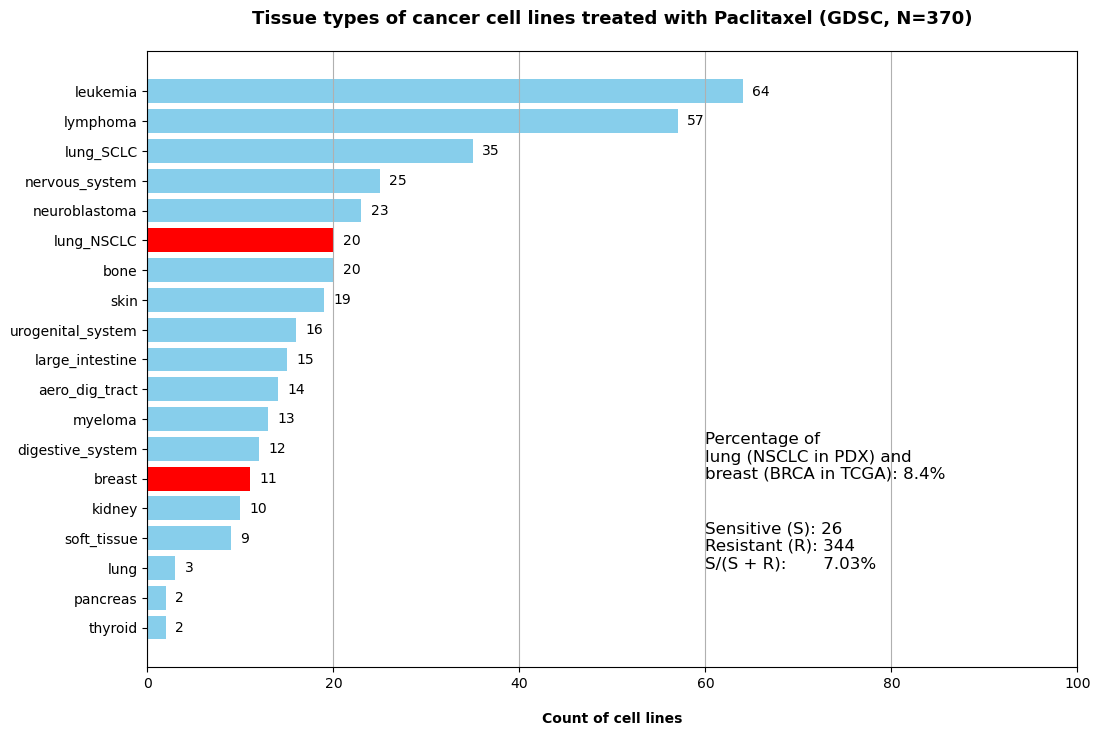

In [43]:
# plot tissue types of cancer cell lines treated with paclitaxel

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with Paclitaxel (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \nlung (NSCLC in PDX) and \nbreast (BRCA in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with Paclitaxel (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [44]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '949167', '998184', '1290771', '1298156', '1330948', '1330993',
       '1503364', '1509073', '1659818', '1659819'],
      dtype='object', length=6360)

In [45]:
# filter GDSC expression, mutation, and CNA datasets (MITOSISi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    m = mut.loc[samples, :]

    expression_zscores.append(e_z)
    CNA.append(c)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls4 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls5 = GDSCEv2.index.intersection(GDSCMv2.index)
ls5 = ls5.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls5, ls4]
GDSCMv2 = GDSCMv2.loc[ls5, ls4]
GDSCCv2 = GDSCCv2.loc[ls5, ls4]
GDSCRv2 = GDSCRv2.loc[ls5, :]

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls4]
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[:,ls4]
TCGACpaclitaxel = TCGACpaclitaxel.loc[:,ls4]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (Mutation): {TCGAMpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (CNA): {TCGACpaclitaxel.shape}\n")

GDSC # of common samples and genes (Expression): (6360, 968)
GDSC # of common samples and genes (Mutation): (6360, 968)
GDSC # of common samples and genes (CNA): (6360, 968)
GDSC # of common samples (Response): 6360

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 968)
TCGA # of common samples and genes for Paclitaxel (Mutation): (35, 968)
TCGA # of common samples and genes for Paclitaxel (CNA): (35, 968)



In [46]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 1]


In [47]:
# change directory to read TCGA response dataset (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [48]:
# read TCGA response dataset (Paclitaxel)

TCGARpaclitaxel = pd.read_csv("TCGA_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARpaclitaxel.dropna(inplace=True)
TCGARpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARpaclitaxel["response"] = TCGARpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel = TCGARpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel.shape[0]} samples with response data in the TCGA (Paclitaxel)\n")
Ytspaclitaxel

There are 35 samples with response data in the TCGA (Paclitaxel)



array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [49]:
# TCGA cohort table with TCGA response dataset (Paclitaxel)

dat_tcga = TCGARpaclitaxel["cohort"]

dat_tcga.value_counts()

cohort
BRCA    27
LUAD     3
UCS      3
STAD     1
HNSC     1
Name: count, dtype: int64

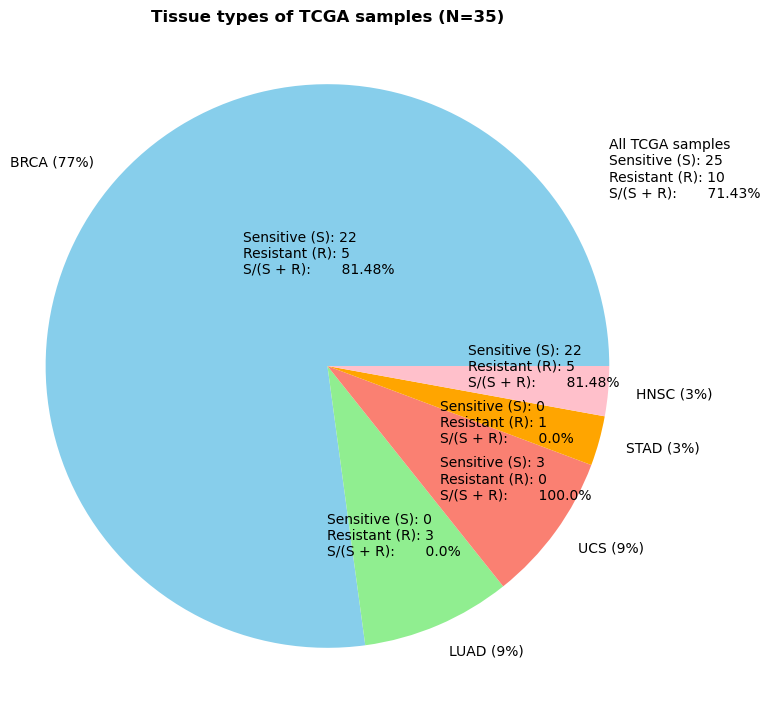

In [50]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue', 'lightgreen', 'salmon', 'orange','pink'])
plt.title(f'Tissue types of TCGA samples (N={total})', fontweight = "bold")
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.3, 0.4, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.4, -0.2, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.4, -0.4, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0, -0.6, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.5, 0, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARpaclitaxel["response"].value_counts()[1]} \nResistant (R): {TCGARpaclitaxel["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel["response"].value_counts()[1]/(sum(TCGARpaclitaxel["response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [51]:
# filter BRCA cohort samples (Paclitaxel)

filter = (TCGARpaclitaxel["cohort"] == "BRCA")
tcga_brca_samples = dat_tcga.loc[filter,].index
tcga_brca_samples

Index(['TCGA-A2-A0EP-01A', 'TCGA-A2-A3XS-01A', 'TCGA-A2-A3XW-01A',
       'TCGA-A2-A3XX-01A', 'TCGA-A2-A3XY-01A', 'TCGA-A2-A4S2-01A',
       'TCGA-A7-A4SA-01A', 'TCGA-A7-A4SE-01A', 'TCGA-A7-A5ZV-01A',
       'TCGA-A7-A5ZX-01A', 'TCGA-A8-A08X-01A', 'TCGA-A8-A09M-01A',
       'TCGA-AQ-A54O-01A', 'TCGA-B6-A402-01A', 'TCGA-D8-A3Z6-01A',
       'TCGA-EW-A1OY-01A', 'TCGA-EW-A1P3-01A', 'TCGA-EW-A2FR-01A',
       'TCGA-GM-A2DA-01A', 'TCGA-GM-A2DB-01A', 'TCGA-GM-A2DF-01A',
       'TCGA-GM-A2DH-01A', 'TCGA-GM-A2DM-01A', 'TCGA-GM-A2DN-01A',
       'TCGA-GM-A3XG-01A', 'TCGA-GM-A3XL-01A', 'TCGA-GM-A3XN-01A'],
      dtype='object', name='sample')

In [52]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_brca = TCGARpaclitaxel.loc[tcga_brca_samples,"response"].values
Ytspaclitaxel_brca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1])

In [53]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

TCGARpaclitaxel.loc[tcga_brca_samples,"response"].value_counts()

response
1    22
0     5
Name: count, dtype: int64

In [54]:
# define maximum iteration

max_iter = 50

In [55]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 64
hdm2 = 256
hdm3 = 512
rate1 = 0.5
rate2 = 0.7
rate3 = 0.3
rate4 = 0.8

In [56]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel = scalerGDSC.transform(TCGAEpaclitaxel.values)    

X_testEpaclitaxel = scalerGDSC.transform(TCGAEpaclitaxel.values)    
X_testEpaclitaxel_brca = scalerGDSC.transform(TCGAEpaclitaxel.loc[tcga_brca_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMpaclitaxel = np.nan_to_num(TCGAMpaclitaxel.values.astype(np.float32))
X_testMpaclitaxel_brca = np.nan_to_num(TCGAMpaclitaxel.loc[tcga_brca_samples,].values.astype(np.float32))

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCpaclitaxel = np.nan_to_num(TCGACpaclitaxel.values.astype(np.float32))
X_testCpaclitaxel_brca = np.nan_to_num(TCGACpaclitaxel.loc[tcga_brca_samples,].values)

TX_testEpaclitaxel = torch.FloatTensor(X_testEpaclitaxel)
TX_testMpaclitaxel = torch.FloatTensor(X_testMpaclitaxel.astype(np.float32))
TX_testCpaclitaxel = torch.FloatTensor(X_testCpaclitaxel.astype(np.float32))
ty_testEpaclitaxelorouracil = torch.FloatTensor(Ytspaclitaxel.astype(int))

TX_testEpaclitaxel = torch.FloatTensor(X_testEpaclitaxel)
TX_testEpaclitaxel_brca = torch.FloatTensor(X_testEpaclitaxel_brca)

TX_testMpaclitaxel = torch.FloatTensor(X_testMpaclitaxel.astype(np.float32))
TX_testMpaclitaxel_brca = torch.FloatTensor(X_testMpaclitaxel_brca.astype(np.float32))

TX_testCpaclitaxel = torch.FloatTensor(X_testCpaclitaxel.astype(np.float32))
TX_testCpaclitaxel_brca = torch.FloatTensor(X_testCpaclitaxel_brca.astype(np.float32))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
h_dim3 = hdm3        
Z_in = h_dim1 + h_dim2 + h_dim3

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       

class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim3),
            nn.BatchNorm1d(h_dim3),
            nn.ReLU(),
            nn.Dropout(rate3))
    def forward(self, x):
        output = self.EnC(x)
        return output 
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate4),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA.pt")
AutoencoderM = torch.load(models_dir + "Mut_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA.pt")

Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA.pt")

AutoencoderE.eval()
AutoencoderM.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (TCGA_MITOSISi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (TCGA_MITOSISi): {round(AUCTaucpr,2)}\n")

ZETpaclitaxel = AutoencoderE(TX_testEpaclitaxel)
ZMTpaclitaxel = AutoencoderM(TX_testMpaclitaxel)
ZCTpaclitaxel = AutoencoderC(TX_testCpaclitaxel)
ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZMTpaclitaxel, ZCTpaclitaxel), 1)
ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
PredTpaclitaxel = Clas(ZTTpaclitaxel)
AUCTpaclitaxel = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"TCGA - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
AUCTpaclitaxel_aucpr = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"TCGA - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}\n")

ZETpaclitaxel_brca = AutoencoderE(TX_testEpaclitaxel_brca)
ZMTpaclitaxel_brca = AutoencoderM(TX_testMpaclitaxel_brca)
ZCTpaclitaxel_brca = AutoencoderC(TX_testCpaclitaxel_brca)
ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZMTpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
PredTpaclitaxel_brca = Clas(ZTTpaclitaxel_brca)
AUCTpaclitaxel_brca = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"TCGA - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
AUCTpaclitaxel_brca_aucpr = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"TCGA - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_finetuned = dict()
AUCTpaclitaxel_brca_finetuned = dict()
AUCTpaclitaxel_aucpr_finetuned = dict()
AUCTpaclitaxel_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(models_dir + f"Finetuned_Models/Mut_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETpaclitaxel = AutoencoderE_finetuned(TX_testEpaclitaxel)
   ZMTpaclitaxel = AutoencoderM_finetuned(TX_testMpaclitaxel)
   ZCTpaclitaxel = AutoencoderC_finetuned(TX_testCpaclitaxel)
   ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZMTpaclitaxel, ZCTpaclitaxel), 1)
   ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
   PredTpaclitaxel = Clas_finetuned(ZTTpaclitaxel)
   AUCTpaclitaxel_finetuned[iter] = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
   AUCTpaclitaxel_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())

   ZETpaclitaxel_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_brca)
   ZMTpaclitaxel_brca = AutoencoderM_finetuned(TX_testMpaclitaxel_brca)
   ZCTpaclitaxel_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_brca)
   ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZMTpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
   ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
   PredTpaclitaxel_brca = Clas_finetuned(ZTTpaclitaxel_brca)
   AUCTpaclitaxel_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
   AUCTpaclitaxel_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())

max_key = max(AUCTpaclitaxel_aucpr_finetuned, key=AUCTpaclitaxel_aucpr_finetuned.get)
max_key_brca = max(AUCTpaclitaxel_brca_aucpr_finetuned, key=AUCTpaclitaxel_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (MITOSISi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (MITOSISi): {round(AUCTaucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"TCGA - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_finetuned[max_key],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_brca],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_brca],2)}")
print(f"TCGA - Test AUC (Paclitaxel, LGG, Finetuned): {round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, LGG, Finetuned): {round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel)")
print(f"Exprs_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Mut_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Class_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Paclitaxel, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"Mut_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"Class_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")

GDSC - Training AUC (MITOSISi): 0.86
GDSC - Training AUCPR (MITOSISi): 0.42
TCGA - Test AUC (Paclitaxel): 0.76
TCGA - Test AUCPR (Paclitaxel): 0.88
TCGA - Test AUC (Paclitaxel, BRCA): 0.85
TCGA - Test AUCPR (Paclitaxel, BRCA): 0.96

GDSC - Training AUC (MITOSISi, Finetuned): 0.86
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.4
TCGA - Test AUC (Paclitaxel, Finetuned): 0.67
TCGA - Test AUCPR (Paclitaxel, Finetuned): 0.88

GDSC - Training AUC (MITOSISi, Finetuned): 0.86
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.42
TCGA - Test AUC (Paclitaxel, LGG, Finetuned): 0.85
TCGA - Test AUCPR (Paclitaxel, LGG, Finetuned): 0.96


Models for maximum finetuning (Paclitaxel)
Exprs_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_2.pt
Mut_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_2.pt
CNA_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_2.pt
Class_Paclitaxel_GDSC_TCGA_MITOSISi_Expression_Mutation_CNA_Finetuned_2.pt

Models for maximum finetuning (

In [57]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=968, out_features=1023, bias=True)
    (1): BatchNorm1d(1023, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [58]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=968, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.7, inplace=False)
  )
)

In [59]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=968, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [60]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=1599, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [61]:
# create a dataframe with the prediction results 

emc = {"Data": ["Expr + Mut + CNA", "Expr + Mut + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (TCGA)": [round(AUCTpaclitaxel,2), round(AUCTpaclitaxel_finetuned[max_key],2)],
       "AUCPR (TCGA)":  [round(AUCTpaclitaxel_aucpr,2), round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)],
       "AUC (TCGA-BRCA)":  [round(AUCTpaclitaxel_brca,2), round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)],
       "AUCPR (TCGA-BRCA)": [round(AUCTpaclitaxel_brca_aucpr,2), round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
emc_dataframe = pd.DataFrame.from_dict(emc, orient='index').transpose()  
emc_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_CNA_MITOSIS_Paclitaxel.tsv",
                    sep = "\t",
                    index = False)

emc_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUC (TCGA-BRCA)": "AUC (TCGA-BRCA, N=" + str(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts())) + ")",
    "AUCPR (TCGA-BRCA)": "AUCPR (TCGA-BRCA, N=" + str(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts())) + ")"

    }, inplace = True
)

emc_dataframe

,Data,"AUC (GDSC, N=6360)","AUCPR (GDSC, N=6360)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut + CNA,0.86,0.42,0.76,0.88,0.85,0.96,6360,968
1,Expr + Mut + CNA (Fine-tuned),0.86,0.4,0.67,0.88,0.85,0.96,6360,968


In [62]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_TCGA_Expression_CNA_MITOSISi_Paclitaxel.tsv",
                           sep = "\t")
ec_dataframe.columns = emc_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_TCGA_Expression_Mutation_MITOSISi_Paclitaxel.tsv",
                           sep = "\t")
em_dataframe.columns = emc_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=6360)","AUCPR (GDSC, N=6360)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.86,0.42,0.76,0.88,0.85,0.96,6360,968
Expr + Mut + CNA (Fine-tuned),0.86,0.4,0.67,0.88,0.85,0.96,6360,968
Expr + CNA,0.79,0.32,0.64,0.79,0.74,0.94,6360,984
Expr + CNA (Fine-tuned),0.8,0.32,0.63,0.8,0.75,0.94,6360,984
Expr + Mut,0.83,0.39,0.66,0.82,0.68,0.87,6360,969
Expr + Mut (Fine-tuned),0.84,0.39,0.68,0.83,0.73,0.9,6360,969


In [63]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (TCGA, N={str(len(Ytspaclitaxel))})",
                               f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_brca))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (TCGA, N={str(len(Ytspaclitaxel))})": f"TCGA (N={str(len(Ytspaclitaxel))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=6360, p=968\nS=602, R=5758, S/N=0.09)","TCGA (N=35, p=968\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=968\nS=22, R=5, S/N=0.81)"
Data,,,
Expr + Mut + CNA,0.86,0.76,0.85
Expr + Mut + CNA (Fine-tuned),0.86,0.67,0.85
Expr + CNA,0.79,0.64,0.74
Expr + CNA (Fine-tuned),0.8,0.63,0.75
Expr + Mut,0.83,0.66,0.68
Expr + Mut (Fine-tuned),0.84,0.68,0.73


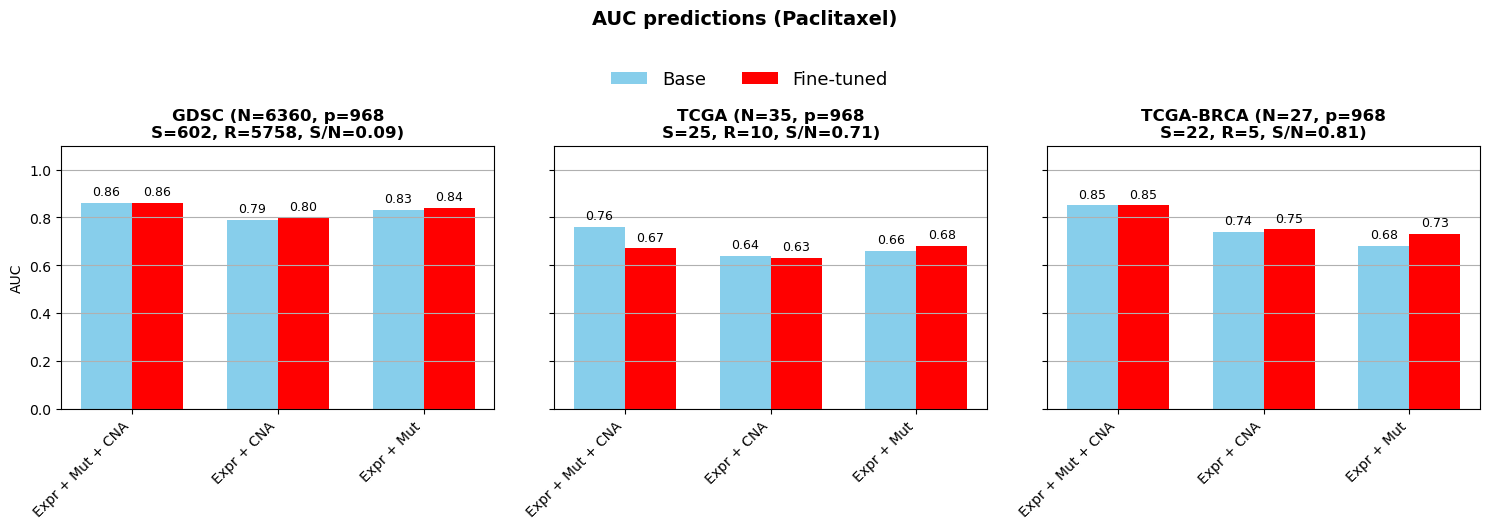

In [64]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [65]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (TCGA, N={str(len(Ytspaclitaxel))})",
                                 f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_brca))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (TCGA, N={str(len(Ytspaclitaxel))})": f"TCGA (N={str(len(Ytspaclitaxel))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=6360, p=968\nS=602, R=5758, S/N=0.09)","TCGA (N=35, p=968\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=968\nS=22, R=5, S/N=0.81)"
Data,,,
Expr + Mut + CNA,0.42,0.88,0.96
Expr + Mut + CNA (Fine-tuned),0.4,0.88,0.96
Expr + CNA,0.32,0.79,0.94
Expr + CNA (Fine-tuned),0.32,0.8,0.94
Expr + Mut,0.39,0.82,0.87
Expr + Mut (Fine-tuned),0.39,0.83,0.9


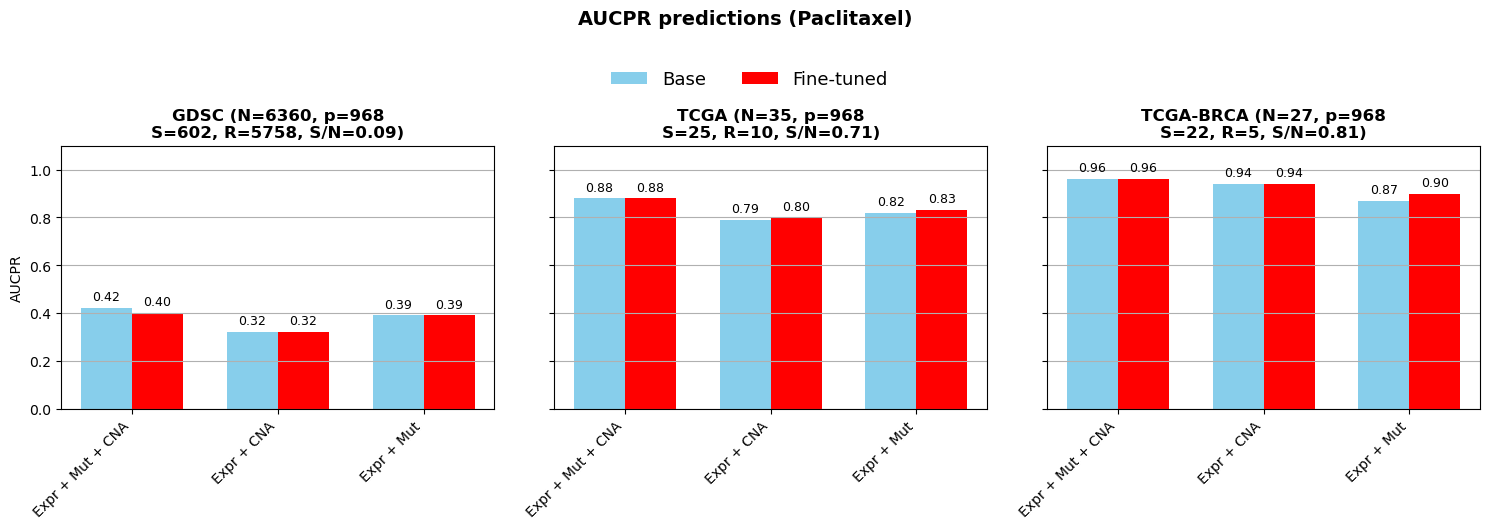

In [66]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [67]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_MITOSISi/Expression_Mutation_CNA/Predictions


In [68]:
# save predictions

file = open('GDSC_TCGA_DEGs - TCGA_MITOSISi_Paclitaxel Predictions (Expression, Mutation, and CNA).txt', 'w')
file.write(f"GDSC Training (EMC) AUC (TCGA_MITOSISi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EMC) AUCPR (TCGA_MITOSISi): {round(AUCTaucpr,2)}\n\n")

file.write(f"TCGA Test (EMC) AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}\n")
file.write(f"TCGA Test (EMC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}\n\n")

file.close()